Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
🚀 STARTING TRAFFIC ANALYSIS PIPELINE

📊 STEP 1: Loading and preprocessing data...
Dataset shape: (33441, 17)

First 5 rows:
     segment_id       date  weekday        period LOS  s_node_id   e_node_id  \
_id                                                                            
0            26 2021-04-16        4   period_0_30   A  366428456   366416066   
1            33 2020-08-02        6  period_23_30   C  366469460  3792257828   
2            33 2020-08-03        0   period_0_00   D  366469460  3792257828   
3            67 2021-03-09        1   period_9_30   B  366403668  5755066033   
4            67 2021-03-23        1   period_9_30   B  366403668  5755066033   

     length  street_id  max_velocity  street_level    street_name street_type  \
_id                                                                             
0       116   32575820  

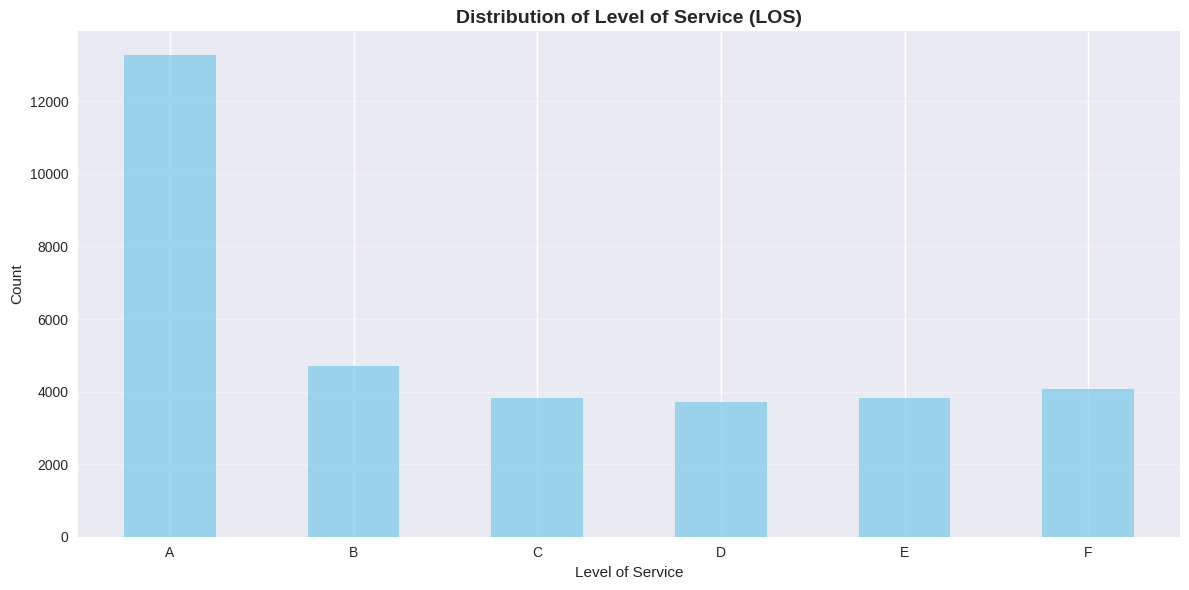

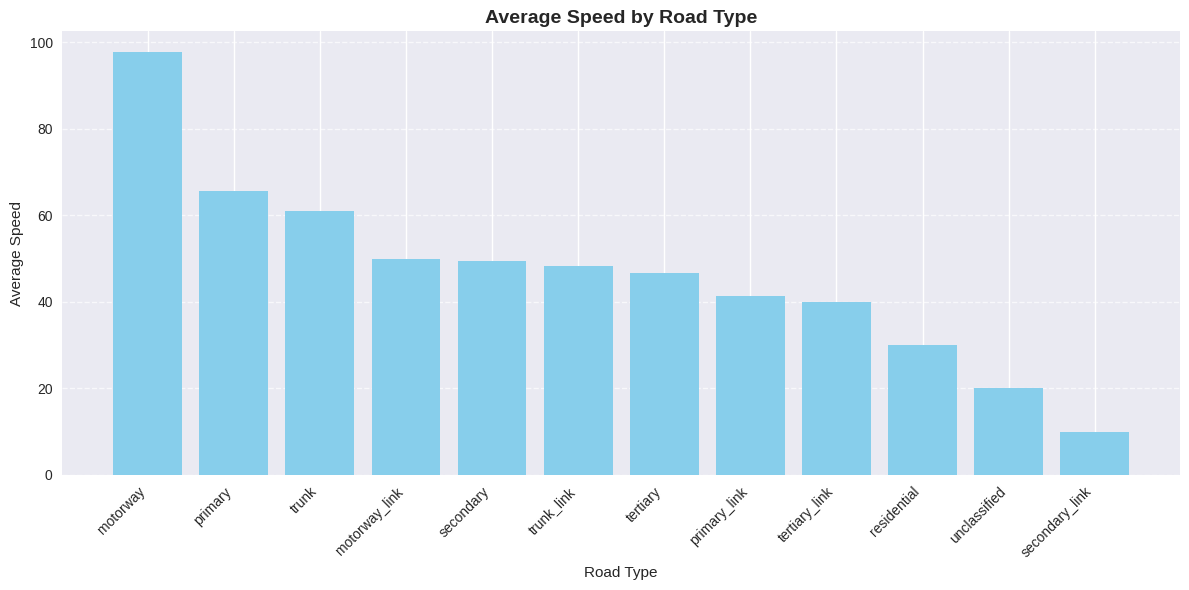


🔍 STEP 3: Performing clustering with fixed parameters...
Features used: ['center_lat', 'center_lng', 'length', 'max_velocity', 'is_weekend', 'is_peak', 'street_level']
RUNNING ALL CLUSTERING MODELS WITH FIXED PARAMETERS

--- DBSCAN Clustering ---

====== DBSCAN Evaluation ======
Số cụm tìm được: 989
Tỷ lệ nhiễu: 52.34%
Silhouette Score (không tính noise): 0.7498923338068826

--- OPTICS Clustering ---


KeyboardInterrupt: 

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import DBSCAN, OPTICS
from sklearn.metrics import silhouette_score
import hdbscan
from sklearn.neighbors import KDTree
import folium
from folium.plugins import MarkerCluster, HeatMap
import warnings
import heapq
import scipy.cluster.hierarchy as sch
import plotly.express as px
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# =============================================================================
# 1. DATA LOADING AND PREPROCESSING
# =============================================================================

def load_and_preprocess_data():
    """Load and preprocess the traffic data"""
    # Load data
    df = pd.read_csv("/content/train.csv",
                     index_col="_id", parse_dates=["date"])

    print("Dataset shape:", df.shape)
    print("\nFirst 5 rows:")
    print(df.head())

    return df

def handle_missing_data(df):
    """Handle missing values in the dataset"""
    # Fill missing max_velocity based on street_type
    avg_max_velocity = df.groupby('street_type')['max_velocity'].mean().sort_values(ascending=False)
    velocity_dict = avg_max_velocity.to_dict()
    df['max_velocity'] = df['max_velocity'].fillna(df['street_type'].map(velocity_dict))
    df.dropna(subset=['max_velocity'], inplace=True)

    # Drop rows with missing street_name
    df.dropna(subset=['street_name'], inplace=True)

    print("Null max_velocity after filling:", df['max_velocity'].isna().sum())
    print("Null street_name after dropping:", df['street_name'].isna().sum())

    return df

def create_features(df):
    """Create new features for analysis"""
    # Select relevant columns
    cols = ["segment_id", "street_id", "s_node_id", "e_node_id", "street_name", "date", "weekday",
            "length", "max_velocity", "street_level", "street_type",
            "long_snode", "lat_snode", "long_enode", "lat_enode", "period", "LOS"]
    df = df[cols]

    # Define peak hours and special days
    peaks = ["period_6_00", "period_6_30", "period_7_00", "period_7_30",
             "period_16_00", "period_16_30", "period_17_00", "period_17_30",
             "period_18_00", "period_18_30"]

    def is_special(date):
        """Check if date is a Vietnamese holiday"""
        holidays = [(1,1), (14,2), (8,3), (30,4), (1,5), (1,6),
                    (2,9), (20,10), (20,11), (24,12), (25,12)]
        return any(date.day == day and date.month == month for day, month in holidays)

    # Create new features
    df["is_weekend"] = df["weekday"].apply(lambda x: int(x in [5, 6]))
    df["is_peak"] = df["period"].apply(lambda p: int(p in peaks))
    df["special_day"] = df["date"].apply(lambda date: int(is_special(date)))

    # Calculate segment center coordinates
    df['center_lat'] = (df['lat_snode'] + df['lat_enode']) / 2
    df['center_lng'] = (df['long_snode'] + df['long_enode']) / 2

    print("Enhanced dataset shape:", df.shape)
    print("New features added: is_weekend, is_peak, special_day, center_lat, center_lng")

    return df

# =============================================================================
# 2. EXPLORATORY DATA ANALYSIS
# =============================================================================

def perform_eda(df):
    """Perform exploratory data analysis"""
    # Check missing values
    missing_df = pd.DataFrame({
        'missing_count': df.isnull().sum(),
        'missing_ratio': df.isnull().sum() / len(df)
    }).sort_values('missing_ratio', ascending=False)

    print("Missing values analysis:")
    print(missing_df[missing_df['missing_count'] > 0])

    # Visualize LOS distribution
    plt.figure(figsize=(12, 6))
    df['LOS'].value_counts().sort_index().plot(kind='bar', color='skyblue', alpha=0.8)
    plt.title('Distribution of Level of Service (LOS)', fontsize=14, fontweight='bold')
    plt.xlabel('Level of Service')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Visualize average speed by road type
    avg_max_velocity = df.groupby('street_type')['max_velocity'].mean().sort_values(ascending=False)
    plt.figure(figsize=(12, 6))
    plt.bar(avg_max_velocity.index, avg_max_velocity.values, color='skyblue')
    plt.title('Average Speed by Road Type', fontsize=14, fontweight='bold')
    plt.xlabel('Road Type')
    plt.ylabel('Average Speed')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# =============================================================================
# 3. CLUSTERING PREPARATION AND OPTIMIZATION
# =============================================================================

def prepare_clustering_features(data, feature_set='comprehensive'):
    """Prepare different feature sets for clustering"""
    if feature_set == 'spatial':
        features = ['center_lat', 'center_lng']
    elif feature_set == 'spatial_length':
        features = ['center_lat', 'center_lng', 'length']
    elif feature_set == 'comprehensive':
        features = ['center_lat', 'center_lng', 'length', 'max_velocity',
                   'is_weekend', 'is_peak', 'street_level']

    # Clean data
    feature_df = data[features].copy()
    feature_df = feature_df.dropna()

    # Encode categorical variables if present
    categorical_features = ['street_level'] if 'street_level' in features else []
    for col in categorical_features:
        le = LabelEncoder()
        feature_df[col] = le.fit_transform(feature_df[col].astype(str))

    # Standardize features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(feature_df)

    return scaled_features, feature_df.index, scaler, features

def evaluate(labels, X):
    """Return Silhouette Score (None if cluster is not valid)"""
    non_noise = labels != -1
    if len(np.unique(labels[non_noise])) < 2:
        return None

    sil = silhouette_score(X[non_noise], labels[non_noise])
    return sil

def evaluate_model(labels, features, model_name):
    """Evaluate clustering model performance"""

    noise_ratio = np.mean(labels == -1) * 100
    n_clusters = len(set(labels) - {-1})  # chính xác hơn

    # ➤ Loại bỏ noise trước khi tính Silhouette
    mask = labels != -1
    if n_clusters > 1 and np.sum(mask) > 1:
        sil = silhouette_score(features[mask], labels[mask])
    else:
        sil = None

    print(f"\n====== {model_name} Evaluation ======")
    print(f"Số cụm tìm được: {n_clusters}")
    print(f"Tỷ lệ nhiễu: {noise_ratio:.2f}%")
    print(f"Silhouette Score (không tính noise): {sil if sil else 'Không thể tính'}")

    return {
        'model': model_name,
        'clusters': n_clusters,
        'noise %': noise_ratio,
        'silhouette': sil
    }

def run_all_clustering_models(features):
    """Chạy cả 3 mô hình clustering với tham số cố định"""

    print("=" * 60)
    print("RUNNING ALL CLUSTERING MODELS WITH FIXED PARAMETERS")
    print("=" * 60)

    # DBSCAN với tham số cố định
    print("\n--- DBSCAN Clustering ---")
    dbscan = DBSCAN(eps=0.06, min_samples=8)
    dbscan_labels = dbscan.fit_predict(features)
    dbscan_eval = evaluate_model(dbscan_labels, features, 'DBSCAN')

    # OPTICS với tham số cố định
    print("\n--- OPTICS Clustering ---")
    optics = OPTICS(min_samples=5, xi=0.10, cluster_method='xi')
    optics_labels = optics.fit_predict(features)
    optics_eval = evaluate_model(optics_labels, features, 'OPTICS')

    # HDBSCAN với tham số cố định
    print("\n--- HDBSCAN Clustering ---")
    hdbscan_model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=5)
    hdbscan_labels = hdbscan_model.fit_predict(features)
    hdbscan_eval = evaluate_model(hdbscan_labels, features, 'HDBSCAN')

    return {
        'dbscan': {'labels': dbscan_labels, 'eval': dbscan_eval},
        'optics': {'labels': optics_labels, 'eval': optics_eval},
        'hdbscan': {'labels': hdbscan_labels, 'eval': hdbscan_eval}
    }

# =============================================================================
# 4. STREET NAME-BASED PATHFINDING (PHẦN MỚI)
# =============================================================================

def find_streets_by_name(df, street_name):
    """Tìm các đường có tên chứa chuỗi nhập vào"""
    street_name_lower = street_name.lower()
    matching_streets = df[df['street_name'].str.lower().str.contains(street_name_lower, na=False)]

    if matching_streets.empty:
        return None

    # Lấy danh sách các đường duy nhất
    unique_streets = matching_streets['street_name'].unique()
    return unique_streets

def get_street_coordinates(df, street_name):
    """Lấy tọa độ trung bình của một đường"""
    street_data = df[df['street_name'] == street_name]

    if street_data.empty:
        return None, None

    # Tính tọa độ trung bình của đường
    avg_lat = street_data['center_lat'].mean()
    avg_lng = street_data['center_lng'].mean()

    return avg_lat, avg_lng

def interactive_street_selection(df, point_type="bắt đầu"):
    """Tương tác chọn đường cho điểm bắt đầu/kết thúc"""

    print(f"\n=== CHỌN ĐƯỜNG CHO ĐIỂM {point_type.upper()} ===")

    while True:
        street_input = input(f"Nhập tên đường cho điểm {point_type} (hoặc 'list' để xem danh sách đường): ").strip()

        if street_input.lower() == 'list':
            # Hiển thị danh sách các đường có trong dataset
            all_streets = df['street_name'].unique()
            print(f"\nDANH SÁCH CÁC ĐƯỜNG CÓ SẴN ({len(all_streets)} đường):")
            for i, street in enumerate(sorted(all_streets)[:50]):  # Hiển thị tối đa 50 đường
                print(f"  {i+1:2d}. {street}")
            if len(all_streets) > 50:
                print(f"  ... và {len(all_streets) - 50} đường khác")
            continue

        # Tìm đường phù hợp
        matching_streets = find_streets_by_name(df, street_input)

        if matching_streets is None or len(matching_streets) == 0:
            print("❌ Không tìm thấy đường nào phù hợp. Vui lòng thử lại.")
            continue

        if len(matching_streets) == 1:
            # Chỉ có một đường phù hợp
            selected_street = matching_streets[0]
            print(f"✅ Đã chọn đường: {selected_street}")
            lat, lng = get_street_coordinates(df, selected_street)
            return lat, lng, selected_street
        else:
            # Có nhiều đường phù hợp
            print(f"\nTìm thấy {len(matching_streets)} đường phù hợp:")
            for i, street in enumerate(matching_streets):
                print(f"  {i+1}. {street}")

            try:
                choice = int(input(f"\nChọn số thứ tự đường (1-{len(matching_streets)}): "))
                if 1 <= choice <= len(matching_streets):
                    selected_street = matching_streets[choice-1]
                    print(f"✅ Đã chọn đường: {selected_street}")
                    lat, lng = get_street_coordinates(df, selected_street)
                    return lat, lng, selected_street
                else:
                    print("❌ Lựa chọn không hợp lệ. Vui lòng thử lại.")
            except ValueError:
                print("❌ Vui lòng nhập số hợp lệ.")

def interactive_path_finding_by_street(df, cluster_column='dbscan_cluster'):
    """Hệ thống tìm đường tương tác qua tên đường"""

    print("=== HỆ THỐNG TÌM ĐƯỜNG THÔNG MINH (THEO TÊN ĐƯỜNG) ===")

    # Chọn đường cho điểm bắt đầu
    start_lat, start_lng, start_street = interactive_street_selection(df, "bắt đầu")
    if start_lat is None:
        print("❌ Không thể xác định điểm bắt đầu.")
        return None

    # Chọn đường cho điểm kết thúc
    goal_lat, goal_lng, goal_street = interactive_street_selection(df, "kết thúc")
    if goal_lat is None:
        print("❌ Không thể xác định điểm kết thúc.")
        return None

    print(f"\n📍 ĐIỂM BẮT ĐẦU: {start_street}")
    print(f"📍 ĐIỂM KẾT THÚC: {goal_street}")

    print("\nĐang tìm đường đi tối ưu...")

    # Tìm đường đi qua các cụm
    cluster_path = a_star_cluster_based(start_lat, start_lng, goal_lat, goal_lng, df, cluster_column)

    if cluster_path:
        print(f"\n🎯 ĐƯỜNG ĐI TỐI ƯU QUA CÁC CỤM:")
        print(" → ".join(map(str, cluster_path)))

        # Tính toán thông tin thống kê
        cluster_info = get_cluster_congestion_cost(df, cluster_column)
        total_cost = sum(cluster_info[cluster_id]['travel_cost'] for cluster_id in cluster_path if cluster_id in cluster_info)
        avg_congestion = total_cost / len(cluster_path)

        print(f"💰 Tổng chi phí: {total_cost:.2f}")
        print(f"📊 Chi phí trung bình mỗi cụm: {avg_congestion:.2f}")

        # Tạo visualization
        print("\n🗺️ Đang tạo bản đồ...")
        map_cluster = create_cluster_path_visualization(
            cluster_path, df, start_lat, start_lng, goal_lat, goal_lng, cluster_column
        )

        # Thêm thông tin đường vào popup
        for feature in map_cluster._children:
            if isinstance(feature, folium.Marker):
                if feature.options['icon']['iconColor'] == 'green':
                    feature.options['popup'] = f"Điểm bắt đầu<br>Đường: {start_street}"
                elif feature.options['icon']['iconColor'] == 'red':
                    feature.options['popup'] = f"Điểm kết thúc<br>Đường: {goal_street}"

        # Lưu bản đồ
        map_file = f"cluster_path_{start_street.replace(' ', '_')}_to_{goal_street.replace(' ', '_')}.html"
        map_cluster.save(map_file)
        print(f"💾 Bản đồ đã được lưu: {map_file}")

        return map_cluster

    else:
        print("❌ Không tìm thấy đường đi!")
        return None

# =============================================================================
# 5. CLUSTER-BASED PATHFINDING FUNCTIONS
# =============================================================================

def calculate_cluster_centers(df, cluster_column='dbscan_cluster'):
    """Tính toán tâm của các cụm"""
    cluster_centers = df.groupby(cluster_column).agg({
        'center_lat': 'mean',
        'center_lng': 'mean'
    }).reset_index()

    # Loại bỏ cụm nhiễu (-1)
    cluster_centers = cluster_centers[cluster_centers[cluster_column] != -1]

    return cluster_centers

def calculate_cluster_adjacency(df, cluster_column='dbscan_cluster', distance_threshold=0.05):
    cluster_centers = calculate_cluster_centers(df, cluster_column)
    cluster_adjacency = {}
    for i, cluster1 in cluster_centers.iterrows():
        cluster_id1 = cluster1[cluster_column]
        lat1, lng1 = cluster1['center_lat'], cluster1['center_lng']
        cluster_adjacency[cluster_id1] = []
        for j, cluster2 in cluster_centers.iterrows():
            if i != j:
                cluster_id2 = cluster2[cluster_column]
                lat2, lng2 = cluster2['center_lat'], cluster2['center_lng']
                distance = np.sqrt((lat1 - lat2)**2 + (lng1 - lng2)**2)
                if distance <= distance_threshold:
                    cluster_adjacency[cluster_id1].append(cluster_id2)
    return cluster_adjacency

def heuristic_cluster(cluster1, cluster2, cluster_info):
    if cluster1 not in cluster_info or cluster2 not in cluster_info:
        return float('inf')
    lat1, lng1 = cluster_info[cluster1]['center_lat'], cluster_info[cluster1]['center_lng']
    lat2, lng2 = cluster_info[cluster2]['center_lat'], cluster_info[cluster2]['center_lng']
    return np.sqrt((lat1 - lat2)**2 + (lng1 - lng2)**2)

def get_cluster_congestion_cost(df, cluster_column='hdbscan_cluster'):
    los_weights = {'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 10}
    cluster_stats = df[df[cluster_column] != -1].groupby(cluster_column).agg({
        'LOS': lambda x: np.mean([los_weights.get(los, 3) for los in x]),
        'center_lat': 'mean',
        'center_lng': 'mean'
    }).rename(columns={'LOS': 'avg_congestion_score'})
    min_score = cluster_stats['avg_congestion_score'].min()
    max_score = cluster_stats['avg_congestion_score'].max()
    if max_score > min_score:
        cluster_stats['travel_cost'] = 1 + (cluster_stats['avg_congestion_score'] - min_score) / (max_score - min_score) * 9
    else:
        cluster_stats['travel_cost'] = 1
    cluster_stats['congestion_ratio'] = cluster_stats['avg_congestion_score'] / max_score if max_score > 0 else 0
    return cluster_stats[['travel_cost', 'center_lat', 'center_lng', 'congestion_ratio']].to_dict('index')



def find_cluster_for_point(lat, lng, df, cluster_column='hdbscan_cluster'):
    """Tìm cụm gần nhất cho một điểm tọa độ"""
    valid_clusters = df[df[cluster_column] != -1]
    if valid_clusters.empty:
        return None
    distances = []
    for cluster_id in valid_clusters[cluster_column].unique():
        cluster_data = valid_clusters[valid_clusters[cluster_column] == cluster_id]
        center_lat = cluster_data['center_lat'].mean()
        center_lng = cluster_data['center_lng'].mean()
        distance = np.sqrt((lat - center_lat)**2 + (lng - center_lng)**2)
        distances.append((cluster_id, distance))
    if distances:
        return min(distances, key=lambda x: x[1])[0]
    return None

def a_star_cluster_based(start_lat, start_lng, goal_lat, goal_lng, df, cluster_column='hdbscan_cluster'):
    start_cluster = find_cluster_for_point(start_lat, start_lng, df, cluster_column)
    goal_cluster = find_cluster_for_point(goal_lat, goal_lng, df, cluster_column)
    if start_cluster is None or goal_cluster is None:
        return []
    cluster_info = get_cluster_congestion_cost(df, cluster_column)
    cluster_adjacency = calculate_cluster_adjacency(df, cluster_column)
    open_set = []
    heapq.heappush(open_set, (0, start_cluster))
    came_from = {}
    g_score = {cluster: float('inf') for cluster in cluster_info.keys()}
    g_score[start_cluster] = 0
    f_score = {cluster: float('inf') for cluster in cluster_info.keys()}
    f_score[start_cluster] = heuristic_cluster(start_cluster, goal_cluster, cluster_info)
    while open_set:
        _, current = heapq.heappop(open_set)
        if current == goal_cluster:
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            return path[::-1]
        for neighbor in cluster_adjacency.get(current, []):
            if neighbor not in cluster_info:
                continue
            base_cost = heuristic_cluster(current, neighbor, cluster_info)
            congestion_cost = cluster_info[neighbor]['travel_cost']
            total_cost = base_cost * congestion_cost
            tentative_g = g_score[current] + total_cost
            if tentative_g < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g
                f_score[neighbor] = tentative_g + heuristic_cluster(neighbor, goal_cluster, cluster_info)
                heapq.heappush(open_set, (f_score[neighbor], neighbor))
    return []

def create_cluster_path_visualization(cluster_path, df, start_lat, start_lng, goal_lat, goal_lng, cluster_column='dbscan_cluster'):
    """Tạo visualization cho đường đi qua các cụm - CHỈ hiển thị các cụm được đi qua"""

    # Lấy thông tin về các cụm
    cluster_info = get_cluster_congestion_cost(df, cluster_column)

    # Tạo bản đồ
    center_lat = (start_lat + goal_lat) / 2
    center_lng = (start_lng + goal_lng) / 2
    m = folium.Map(location=[center_lat, center_lng], zoom_start=13)

    # CHỈ vẽ các cụm có trong đường đi (cluster_path)
    path_coords = []
    for cluster_id in cluster_path:
        if cluster_id in cluster_info:
            info = cluster_info[cluster_id]
            color = 'green' if info['travel_cost'] <= 3 else 'orange' if info['travel_cost'] <= 6 else 'red'

            # Vẽ cụm
            folium.CircleMarker(
                location=[info['center_lat'], info['center_lng']],
                radius=10 + info['travel_cost'] * 2,  # Kích thước tỷ lệ với chi phí
                popup=f'Cụm {cluster_id}<br>Chi phí: {info["travel_cost"]:.2f}<br>Ùn tắc: {info["congestion_ratio"]:.1%}',
                color=color,
                fillColor=color,
                fillOpacity=0.6
            ).add_to(m)

            # Thêm tọa độ vào đường đi
            lat, lng = info['center_lat'], info['center_lng']
            path_coords.append([lat, lng])

    # Vẽ đường đi qua các cụm
    if path_coords:
        # Vẽ đường nối các cụm
        folium.PolyLine(
            path_coords,
            color='blue',
            weight=4,
            opacity=0.8,
            popup='Đường đi tối ưu qua các cụm'
        ).add_to(m)

        # Thêm mũi tên chỉ hướng
        for i in range(len(path_coords) - 1):
            start_point = path_coords[i]
            end_point = path_coords[i + 1]

            # Tính điểm giữa để đặt mũi tên
            mid_point = [
                (start_point[0] + end_point[0]) / 2,
                (start_point[1] + end_point[1]) / 2
            ]

            # Tạo mũi tên
            arrow = folium.RegularPolygonMarker(
                location=mid_point,
                number_of_sides=3,
                radius=8,
                rotation=np.degrees(np.arctan2(end_point[1]-start_point[1], end_point[0]-start_point[0])),
                color='blue',
                fillColor='blue',
                fillOpacity=0.8
            )
            arrow.add_to(m)

    # Đánh dấu điểm bắt đầu và kết thúc
    folium.Marker(
        [start_lat, start_lng],
        popup='Điểm bắt đầu',
        icon=folium.Icon(color='green', icon='play', prefix='fa')
    ).add_to(m)

    folium.Marker(
        [goal_lat, goal_lng],
        popup='Điểm kết thúc',
        icon=folium.Icon(color='red', icon='stop', prefix='fa')
    ).add_to(m)

    # Thêm legend
    legend_html = f'''
    <div style="position: fixed;
                top: 10px; left: 10px; width: 300px; height: 220px;
                background-color: white; border:2px solid grey; z-index:9999;
                font-size:14px; padding: 10px; border-radius: 10px;
                box-shadow: 0 0 10px rgba(0,0,0,0.5);">
    <h4 style="margin-top:0; text-align:center;">CHÚ GIẢI</h4>
    <p><span style="background:green; width:15px; height:15px; display:inline-block; margin-right:5px; border-radius:50%;"></span> Cụm ít ùn tắc</p>
    <p><span style="background:orange; width:15px; height:15px; display:inline-block; margin-right:5px; border-radius:50%;"></span> Cụm ùn tắc trung bình</p>
    <p><span style="background:red; width:15px; height:15px; display:inline-block; margin-right:5px; border-radius:50%;"></span> Cụm ùn tắc nhiều</p>
    <p><i style="background:blue; width:20px; height:3px; display:inline-block; margin-right:5px;"></i> Đường đi tối ưu</p>
    <p><i class="fa fa-play" style="color:green; margin-right:5px;"></i> Điểm bắt đầu</p>
    <p><i class="fa fa-stop" style="color:red; margin-right:5px;"></i> Điểm kết thúc</p>
    <p>• Kích thước: Mức độ ùn tắc</p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(legend_html))

    return m

# =============================================================================
# 6. CLUSTER VISUALIZATION
# =============================================================================

def create_cluster_visualization(df, cluster_labels, model_name):
    """Tạo visualization cho kết quả clustering"""

    # Tạo bản đồ
    center_lat = df['center_lat'].mean()
    center_lng = df['center_lng'].mean()
    m = folium.Map(location=[center_lat, center_lng], zoom_start=12)

    # Màu sắc cho các cụm
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred',
              'beige', 'darkblue', 'darkgreen', 'cadetblue', 'darkpurple']

    # Vẽ các điểm theo cụm
    for cluster_id in np.unique(cluster_labels):
        if cluster_id == -1:
            color = 'gray'  # Noise points
            cluster_name = 'Noise'
        else:
            color = colors[cluster_id % len(colors)]
            cluster_name = f'Cluster {cluster_id}'

        cluster_points = df[cluster_labels == cluster_id]

        for _, point in cluster_points.iterrows():
            folium.CircleMarker(
                location=[point['center_lat'], point['center_lng']],
                radius=5,
                popup=f'{cluster_name}<br>LOS: {point["LOS"]}',
                color=color,
                fillColor=color,
                fillOpacity=0.6
            ).add_to(m)

    # Thêm legend
    legend_html = f'''
    <div style="position: fixed;
                top: 10px; left: 10px; width: 250px; height: auto;
                background-color: white; border:2px solid grey; z-index:9999;
                font-size:14px; padding: 10px; border-radius: 10px;
                box-shadow: 0 0 10px rgba(0,0,0,0.5);">
    <h4 style="margin-top:0; text-align:center;">{model_name} Clusters</h4>
    <p><span style="background:gray; width:15px; height:15px; display:inline-block; margin-right:5px; border-radius:50%;"></span> Noise</p>
    '''

    for i, color in enumerate(colors[:min(6, len(np.unique(cluster_labels))-1)]):
        legend_html += f'<p><span style="background:{color}; width:15px; height:15px; display:inline-block; margin-right:5px; border-radius:50%;"></span> Cluster {i}</p>'

    legend_html += '</div>'
    m.get_root().html.add_child(folium.Element(legend_html))

    return m

def compare_clustering_results(df, clustering_results):
    """So sánh kết quả của 3 mô hình clustering"""

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('COMPARISON OF CLUSTERING MODELS', fontsize=16, fontweight='bold')

    # Biểu đồ 1: Số lượng cụm
    models = ['DBSCAN', 'OPTICS', 'HDBSCAN']
    n_clusters = [
        clustering_results['dbscan']['eval']['clusters'],
        clustering_results['optics']['eval']['clusters'],
        clustering_results['hdbscan']['eval']['clusters']
    ]

    bars1 = axes[0, 0].bar(models, n_clusters, color=['skyblue', 'lightgreen', 'lightcoral'])
    axes[0, 0].set_title('Number of Clusters', fontweight='bold')
    axes[0, 0].set_ylabel('Number of Clusters')
    for bar, value in zip(bars1, n_clusters):
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                       f'{value}', ha='center', va='bottom', fontweight='bold')

    # Biểu đồ 2: Tỷ lệ nhiễu
    noise_ratios = [
        clustering_results['dbscan']['eval']['noise %'],
        clustering_results['optics']['eval']['noise %'],
        clustering_results['hdbscan']['eval']['noise %']
    ]

    bars2 = axes[0, 1].bar(models, noise_ratios, color=['skyblue', 'lightgreen', 'lightcoral'])
    axes[0, 1].set_title('Noise Ratio', fontweight='bold')
    axes[0, 1].set_ylabel('Noise Ratio (%)')
    for bar, value in zip(bars2, noise_ratios):
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                       f'{value:.1f}%', ha='center', va='bottom', fontweight='bold')

    # Biểu đồ 3: Silhouette Score
    silhouettes = [
        clustering_results['dbscan']['eval']['silhouette'] or 0,
        clustering_results['optics']['eval']['silhouette'] or 0,
        clustering_results['hdbscan']['eval']['silhouette'] or 0
    ]

    bars3 = axes[1, 0].bar(models, silhouettes, color=['skyblue', 'lightgreen', 'lightcoral'])
    axes[1, 0].set_title('Silhouette Score', fontweight='bold')
    axes[1, 0].set_ylabel('Silhouette Score')
    for bar, value in zip(bars3, silhouettes):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{value:.3f}' if value > 0 else 'N/A',
                       ha='center', va='bottom', fontweight='bold')

    # Biểu đồ 4: Phân bố cụm
    cluster_sizes = []
    for model_name in ['dbscan', 'optics', 'hdbscan']:
        labels = clustering_results[model_name]['labels']
        unique, counts = np.unique(labels, return_counts=True)
        cluster_sizes.append(counts[unique != -1])  # Loại bỏ noise

    axes[1, 1].boxplot(cluster_sizes, labels=models)
    axes[1, 1].set_title('Cluster Size Distribution', fontweight='bold')
    axes[1, 1].set_ylabel('Number of Points per Cluster')

    plt.tight_layout()
    plt.show()

    return fig

# =============================================================================
# 7. MAIN EXECUTION
# =============================================================================

def main():
    """Hàm chính để chạy toàn bộ pipeline"""
    print("🚀 STARTING TRAFFIC ANALYSIS PIPELINE")
    print("=" * 60)

    # 1. Load and preprocess data
    print("\n📊 STEP 1: Loading and preprocessing data...")
    df = load_and_preprocess_data()
    df = handle_missing_data(df)
    df = create_features(df)

    # 2. Exploratory Data Analysis
    print("\n📈 STEP 2: Performing exploratory data analysis...")
    perform_eda(df)

    # 3. Clustering với tham số cố định
    print("\n🔍 STEP 3: Performing clustering with fixed parameters...")
    features, feature_indices, scaler, feature_names = prepare_clustering_features(df, 'comprehensive')
    print(f"Features used: {feature_names}")

    # Chạy cả 3 mô hình clustering
    clustering_results = run_all_clustering_models(features)

    # Thêm kết quả clustering vào dataframe
    df['dbscan_cluster'] = clustering_results['dbscan']['labels']
    df['optics_cluster'] = clustering_results['optics']['labels']
    df['hdbscan_cluster'] = clustering_results['hdbscan']['labels']

    # # 4. So sánh kết quả clustering
    print("\n📊 STEP 4: Comparing clustering results...")
    compare_clustering_results(df, clustering_results)

    # 5. Trực quan hóa kết quả clustering
    print("\n🗺️ STEP 5: Creating cluster visualizations...")

    # Tạo bản đồ cho từng mô hình
    dbscan_map = create_cluster_visualization(df, df['dbscan_cluster'], 'DBSCAN')
    optics_map = create_cluster_visualization(df, df['optics_cluster'], 'OPTICS')
    hdbscan_map = create_cluster_visualization(df, df['hdbscan_cluster'], 'HDBSCAN')

    # Lưu bản đồ
    # # dbscan_map.save('dbscan_clusters.html')
    # # optics_map.save('optics_clusters.html')
    # hdbscan_map.save('hdbscan_clusters.html')

    print("Bản đồ clustering đã được lưu:")
    # print("- dbscan_clusters.html")
    # print("- optics_clusters.html")
    # print("- hdbscan_clusters.html")

    # 6. Cluster-based Pathfinding bằng tên đường
    print("\n🗺️ STEP 6: Running cluster-based pathfinding by street name...")
    map_result = interactive_path_finding_by_street(df, 'hdbscan_cluster')

    print("\n✅ PIPELINE COMPLETED!")
    return df, clustering_results, map_result

# Chạy chương trình
if __name__ == "__main__":
    df_result, clustering_results, map_viz = main()